# Gauge transformation in the GPU including the z dependence

### Set parameters and enviroment variables

In [1]:
import numpy as np

# hbar * c [GeV * fm]
hbarc = 0.197326 

# Simulation box 
L = 2         
N = 128 
tau_sim = 1     
DTS = 8     

# Glasma fields
su_group = 'su3'
Qs = 2        
ns = 50    
factor = 0.8        
g2mu = Qs / factor     
g = np.pi * np.sqrt(1 / np.log(Qs / 0.2))          		
mu = g2mu / g**2          	
ir = 0.1 * g**2 * mu         
uv = 10.0       

# TODO: Run more events
nevents = 1

In [2]:
import os

os.environ["MY_NUMBA_TARGET"] = "cuda"
os.environ["PRECISION"] = "double"
os.environ['GAUGE_GROUP'] = su_group

# Import relevant modules
import sys
sys.path.append('..')

# Glasma modules
import curraun.core as core
import curraun.mv as mv
import curraun.initial as initial
initial.DEBUG = False

import curraun.su as su
from curraun.numba_target import use_cuda
if use_cuda:
    from numba import cuda

import curraun.su as su
import curraun.lc_gauge as lc_gauge

/home2/carlos.lamas/condacurraun/lib/python3.10/site-packages/scipy/__init__.py:132: UserWarning: A NumPy version >=1.21.6 and <1.28.0 is required for this version of SciPy (detected version 1.21.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Using CUDA
Using SU(3)
Using double precision


### We define the simulation routine

In [3]:

from tqdm import tqdm

# Simulation rutine
def simulate():
    output = {}
    
    # Derived parameters
    a = L/N
    E0 = N / L * hbarc
    DT = 1.0 / DTS
    maxt = int(tau_sim / a * DTS)
    
    # We create the object simulation
    s = core.Simulation(N, DT, g)

    # We initilize the Glasma fields
    va = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    vb = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    initial.init(s, va, vb)
    
    # We create the necessary objects for the gauge transformations
    nplus = maxt//DTS
    lc = lc_gauge.LCGaugeTransf(s, nplus)
    
    # We create the object where we will store the transformed field
    uplus_lc = su.GROUP_TYPE(np.zeros((maxt//DTS-1, N*N, su.GROUP_ELEMENTS)))
    
    
    with tqdm(total=maxt) as pbar:
        for t in range(maxt):            
            # Evolve Glasma fields
            core.evolve_leapfrog(s)
            
            if t == 1:
                lc.initialize_lc()

            if t%DTS == 0 and t!=0:
                
                xplus = t//DTS
                lc.evolve_lc(xplus)

                uplus_lc[xplus-1] = lc.up_lc.copy()
            
            pbar.update(1)

    if use_cuda:
        cuda.current_context().deallocations.clear()
        
    
    # We write the transformed fields in a dictionary
    output["nplus"] = nplus
    output["uplus_lc"] = uplus_lc
    
    return output

In [4]:
# We perform the simulation

import warnings
warnings.filterwarnings('ignore')

output = simulate()

100%|██████████| 512/512 [00:06<00:00, 76.00it/s] 


In [5]:
# We introduce the outputs in variables

uplus_lc = output["uplus_lc"]
nplus = output["nplus"]

print(np.shape(uplus_lc))

(63, 16384, 9)


We plot the transformed fields

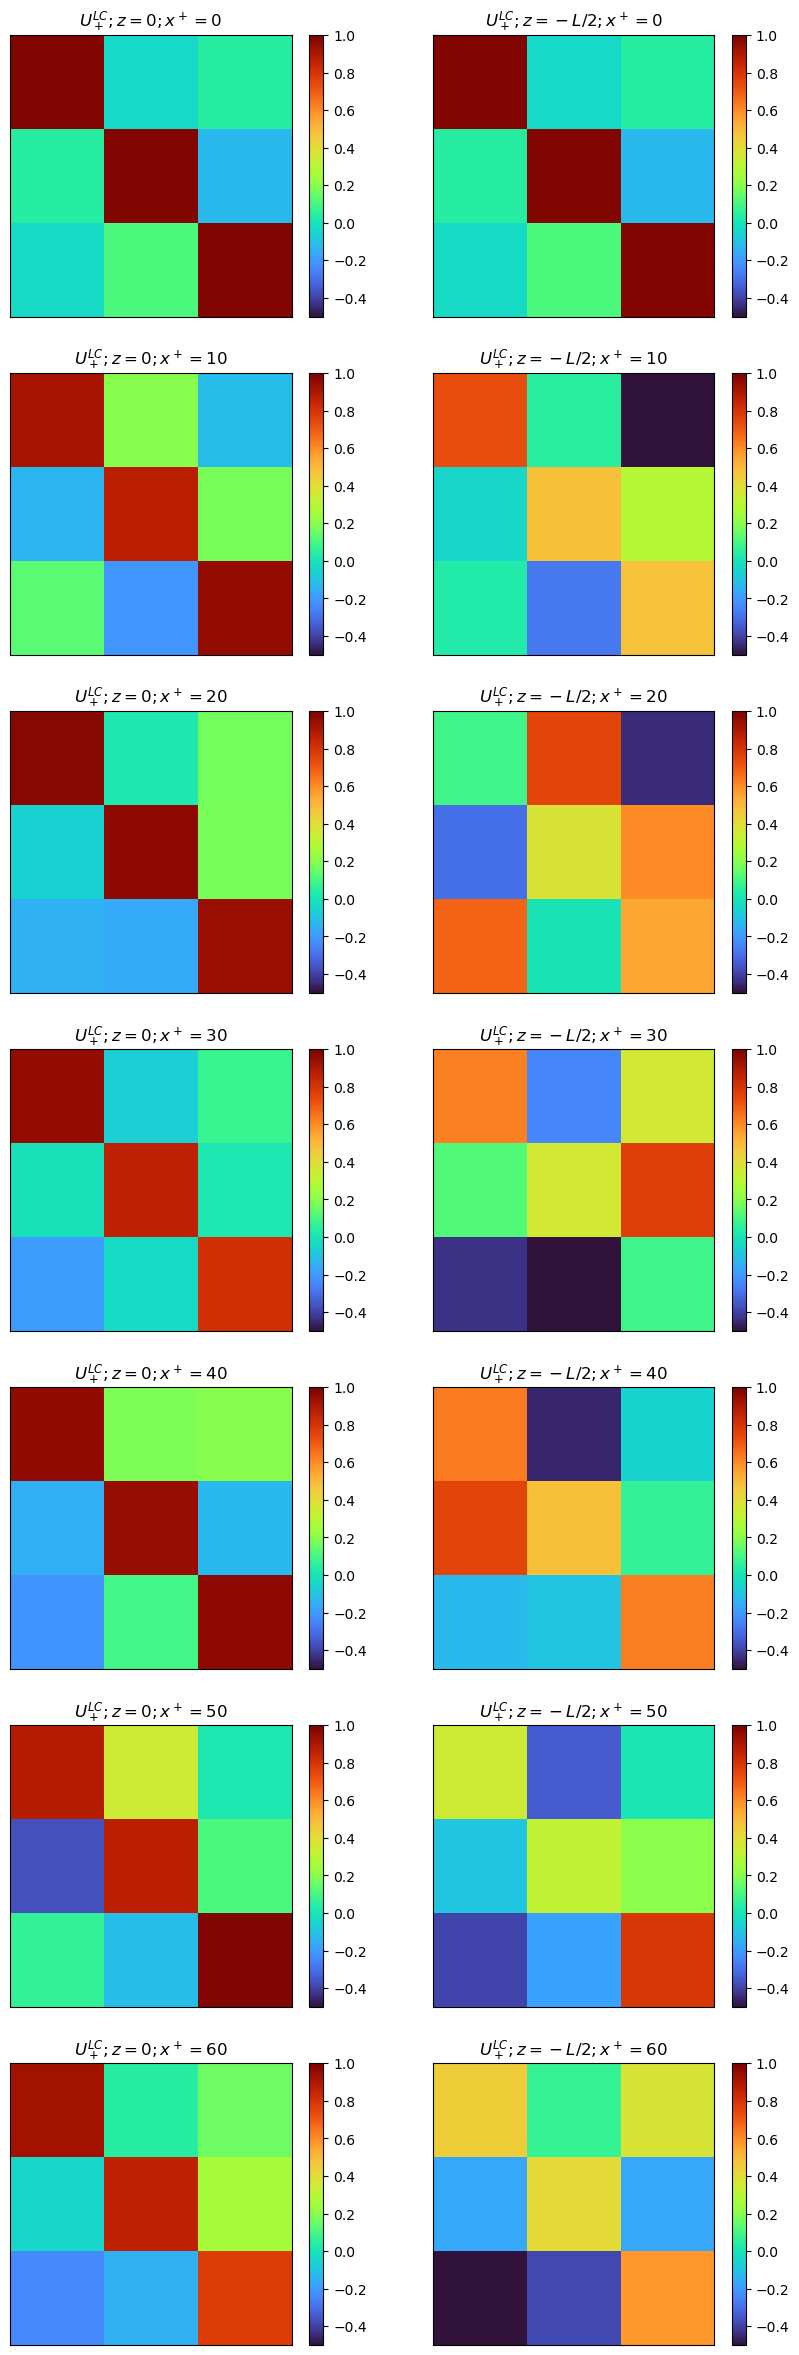

In [6]:
import matplotlib.pyplot as plt

y = N//2
t_steps = N//L*tau_sim

uplus_lc_plot = uplus_lc.reshape(t_steps-1, N, N, 3, 3)

fig, axs = plt.subplots(t_steps//10 +1, 2, figsize=(10,30))

for t in range(t_steps//10 + 1): 
    tau = 10*t
    plot1 = axs[t,0].imshow(uplus_lc_plot[tau, y, N//2, :, :].real, cmap='turbo', vmin=-0.5, vmax=1) 
    axs[t,0].set_title(r'$U_+^{LC}; z =0; x^+ = %i $' %tau)
    plt.colorbar(plot1, ax = axs[t,0])
    axs[t,0].axes.get_xaxis().set_visible(False)
    axs[t,0].axes.get_yaxis().set_visible(False)
    
    plot1 = axs[t, 1].imshow(uplus_lc_plot[tau, y, 0, :, :].real, cmap='turbo', vmin=-0.5, vmax=1)
    axs[t,1].set_title(r'$U_+^{LC}; z = -L/2; x^+ = %i $' %tau)
    plt.colorbar(plot1, ax = axs[t,1])
    axs[t,1].axes.get_xaxis().set_visible(False)
    axs[t,1].axes.get_yaxis().set_visible(False)

## Debug

### Run both the GPU and CPU codes using numba in the same loop

In [1]:
import numpy as np

# hbar * c [GeV * fm]
hbarc = 0.197326 

# Simulation box 
L = 2         
N = 128 
tau_sim = 1     
DTS = 8     

# Glasma fields
su_group = 'su3'
Qs = 2        
ns = 50    
factor = 0.8        
g2mu = Qs / factor     
g = np.pi * np.sqrt(1 / np.log(Qs / 0.2))          		
mu = g2mu / g**2          	
ir = 0.1 * g**2 * mu         
uv = 10.0       

# TODO: Run more events
nevents = 1

In [2]:
import os

os.environ["MY_NUMBA_TARGET"] = "numba"
os.environ["PRECISION"] = "double"
os.environ['GAUGE_GROUP'] = su_group

# Import relevant modules
import sys
sys.path.append('..')

# Glasma modules
import curraun.core as core
import curraun.mv as mv
import curraun.initial as initial
initial.DEBUG = False

import curraun.su as su
from curraun.numba_target import use_cuda
if use_cuda:
    from numba import cuda

import curraun.su as su
import curraun.lc_gauge as lc_gauge
import curraun.gauge_transformation as gt

# Group and algebra factors
Nc = su.NC
Dg = su.GROUP_ELEMENTS

Using Numba
Using SU(3)
Using double precision


/home2/carlos.lamas/condacurraun/lib/python3.10/site-packages/scipy/__init__.py:132: UserWarning: A NumPy version >=1.21.6 and <1.28.0 is required for this version of SciPy (detected version 1.21.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
from tqdm import tqdm

# Simulation rutine
def simulate():
    output = {}
    
    # Derived parameters
    a = L/N
    E0 = N / L * hbarc
    DT = 1.0 / DTS
    maxt = int(tau_sim / a * DTS)
    
    # We create the object simulation
    s = core.Simulation(N, DT, g)

    # We initilize the Glasma fields
    va = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    vb = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    initial.init(s, va, vb)
    
    # We create the necessary objects for the gauge transformations
    nplus = maxt//DTS
    lc = lc_gauge.LCGaugeTransf(s, nplus)
    
    # We create the object where we will store the transformed field
    uplus_lc = su.GROUP_TYPE(np.zeros((maxt//DTS-1, N*N, su.GROUP_ELEMENTS)))
    
    # We create the objects to perform the testing
    uplus_lc_test = su.GROUP_TYPE(np.zeros((maxt//DTS-1, N, N, su.GROUP_ELEMENTS)))
    uplus_temp_test = su.GROUP_TYPE(np.zeros((N, N, su.GROUP_ELEMENTS)))
    v_lc_test = su.GROUP_TYPE([[[su.unit() for z in range (N)] for y in range(N)] for xplus in range (maxt//DTS)])
    
    
    with tqdm(total=maxt) as pbar:
        for t in range(maxt):            
            # Evolve Glasma fields
            core.evolve_leapfrog(s)
            
            # We perform the GPU transformation
            
            if t == 1:
                lc.initialize_lc()

            if t%DTS == 0 and t!=0:
                
                xplus = t//DTS
                lc.evolve_lc(xplus)

                uplus_lc[xplus-1] = lc.up_lc.copy()
            
            
            # We perform the CPU transformation
            
            if t%DTS == 0 or t == 1:
                
                # We copy the fields
                u1 = s.u1.copy()
                ux = u1[:,0,:].reshape(N,N,Dg)
                ae = s.aeta1.copy().reshape(N, N, Dg)
                
                
                # We construct the gauge operator and transform the field
                for xplus in range(maxt//DTS):
                    for y in range(N):
                        for z  in range(N):
                            
                            v_prev = v_lc_test[xplus, y, z]
                            
                            if t == 1: # We initialize the gauge operator
                                uplus_temp_test[y, z] = gt.get_plus_links(ux[0, y], ae[0, y], z, N, t/DTS)
                                v_lc_test[xplus, y, z] = gt.gauge_transformation_operator(ux[2*xplus,y], ae[2*xplus,y], v_prev, z, N, t/DTS)
                            
                            elif xplus > (t//DTS) and t!=0: # We construct the gauge operator
                                v_lc_test[xplus, y, z] = gt.gauge_transformation_operator(ux[2*xplus-t//DTS,y], ae[2*xplus-t//DTS,y], v_prev, z, N, t/DTS)
                                
                            elif xplus == (t//DTS) and t!=0: # We transform the plus links
                                uplus_lc_test[xplus-1, y, z] = gt.act_on_links(uplus_temp_test[y, z], v_lc_test[xplus, y, z], v_lc_test[xplus-1, y, z])
                                uplus_temp_test[y, z] = gt.get_plus_links(ux[xplus, y], ae[xplus, y], z, N, t/DTS)
                            
                            
            
                
                
                
            
            
            pbar.update(1)

    if use_cuda:
        cuda.current_context().deallocations.clear()
        
    
    # We write the transformed fields on the GPU in a dictionary
    output["nplus"] = nplus
    output["uplus_lc"] = uplus_lc
    output["uplus_lc_test"] = uplus_lc_test
    
    return output

In [4]:
# We perform the simulation

import warnings
warnings.filterwarnings('ignore')

output = simulate()

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Kernel xi: 0 d:  0 did not reach goal. check:  0.0008172862526981119
Kernel xi: 0 d:  1 did not reach goal. check:  0.0008477762651571154
Kernel xi: 1 d:  0 did not reach goal. check:  0.001104526900854458
Kernel xi: 1 d:  1 did not reach goal. check:  0.0008467863271758467
Kernel xi: 2 d:  0 did not reach goal. check:  0.0013038912267353227
Kernel xi: 2 d:  1 did not reach goal. check:  0.0006693070543616902
Kernel xi: 3 d:  0 did not reach goal. check:  0.0012828626846735152
Kernel xi: 3 d:  1 did not reach goal. check:  0.00044463696281848194
Kernel xi: 4 d:  0 did not reach goal. check:  0.0010062608249329474
Kernel xi: 4 d:  1 did not reach goal. check:  0.00023964257457123394
Kernel xi: 5 d:  0 did not reach goal. check:  0.0006370098877387214
Kernel xi: 5 d:  1 did not reach goal. check:  0.00012923348540850945
Kernel xi: 6 d:  0 did not reach goal. check:  0.0004397095479685989
Kernel xi: 6 d:  1 did not reach goal. check:  0.00010799056993182481
Kernel xi: 7 d:  0 did not reac

100%|██████████| 512/512 [02:44<00:00,  3.12it/s]


In [5]:
# We extract the simulation results

uplus_lc = su.GROUP_TYPE(output["uplus_lc"]).reshape(N//L*tau_sim-1, N, N, Dg)
uplus_lc_test = su.GROUP_TYPE(output["uplus_lc_test"])

In [6]:
print(np.shape(uplus_lc))
print(np.shape(uplus_lc_test))

(63, 128, 128, 9)
(63, 128, 128, 9)


In [7]:
# We compare the results of both simulations

uplus_lc == uplus_lc_test

array([[[[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]],

        [[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]],

        [[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, Fa

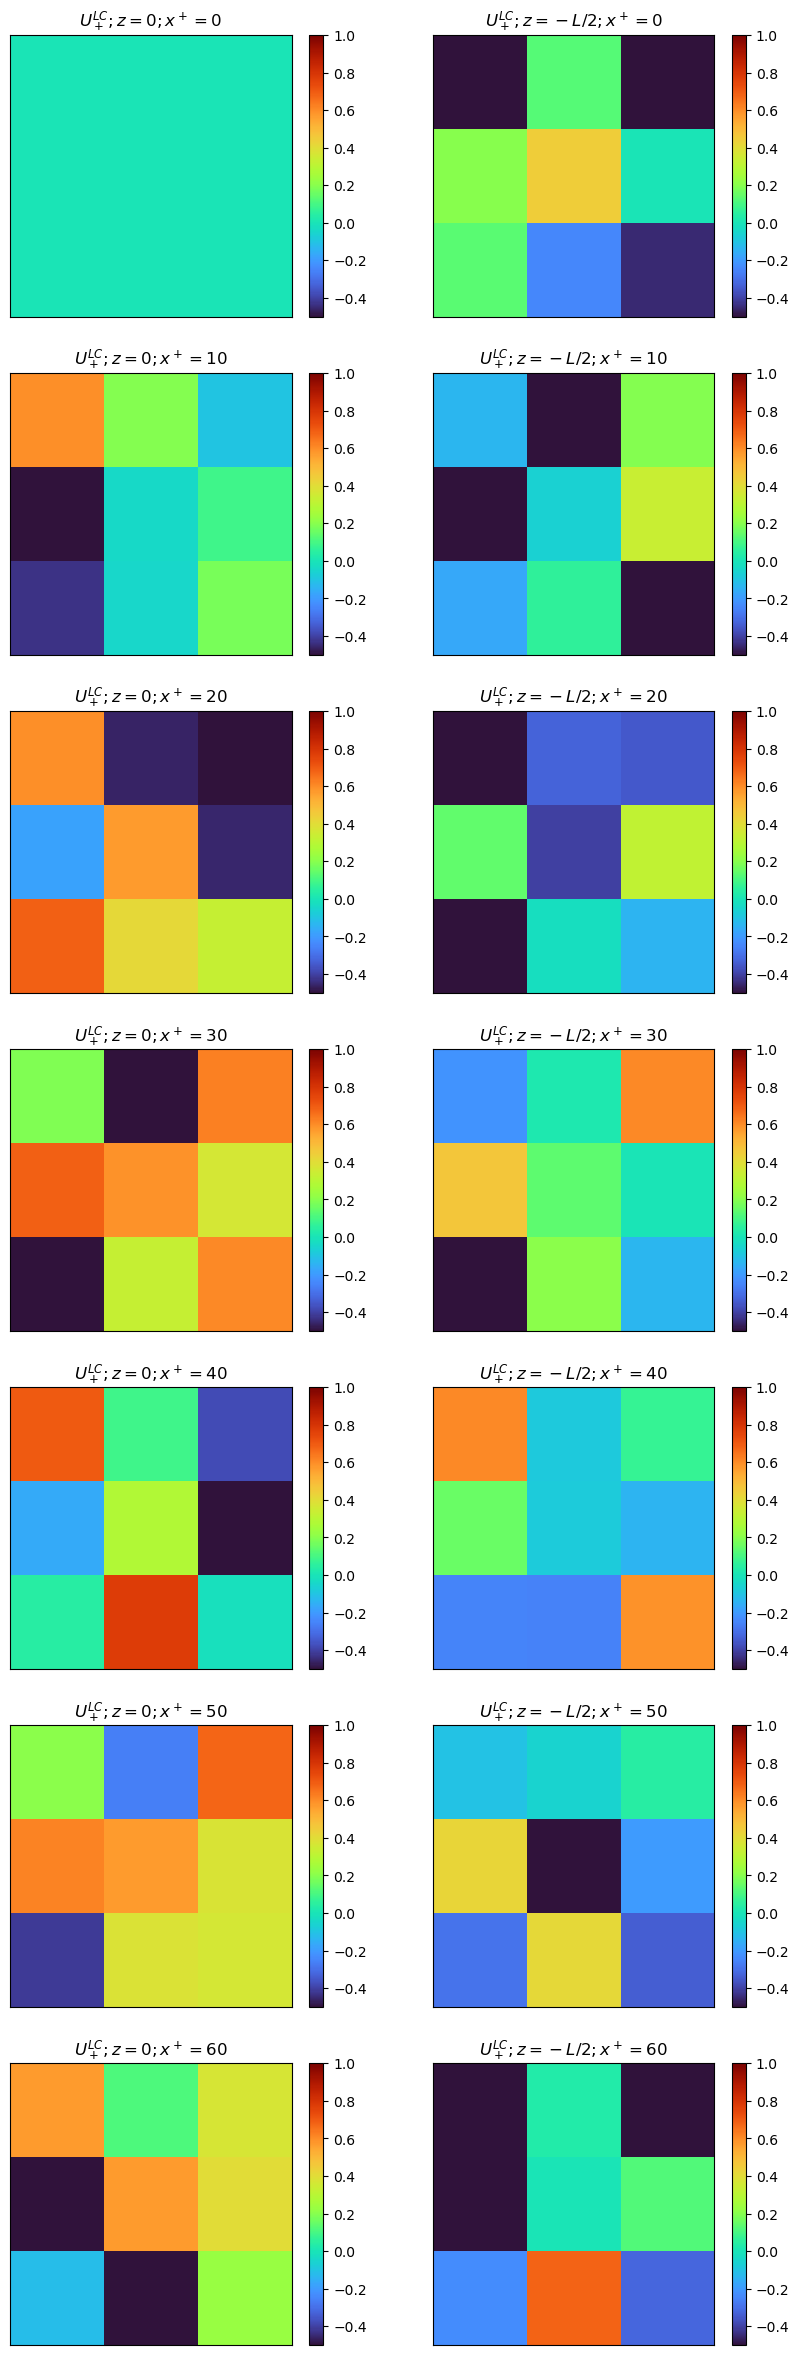

In [8]:
import matplotlib.pyplot as plt

y = N//2
t_steps = N//L*tau_sim

uplus_lc_plot = uplus_lc.reshape(t_steps-1, N, N, 3, 3)
uplus_lc_test_plot = uplus_lc_test.reshape(t_steps-1, N, N, 3, 3)

fig, axs = plt.subplots(t_steps//10 +1, 2, figsize=(10,30))

for t in range(t_steps//10 + 1): 
    tau = 10*t
    plot1 = axs[t,0].imshow(uplus_lc_plot[tau, y, 0, :, :].real, cmap='turbo', vmin=-0.5, vmax=1) 
    axs[t,0].set_title(r'$U_+^{LC}; z =0; x^+ = %i $' %tau)
    plt.colorbar(plot1, ax = axs[t,0])
    axs[t,0].axes.get_xaxis().set_visible(False)
    axs[t,0].axes.get_yaxis().set_visible(False)
    
    plot1 = axs[t, 1].imshow(uplus_lc_test_plot[tau, y, 0, :, :].real, cmap='turbo', vmin=-0.5, vmax=1)
    axs[t,1].set_title(r'$U_+^{LC}; z = -L/2; x^+ = %i $' %tau)
    plt.colorbar(plot1, ax = axs[t,1])
    axs[t,1].axes.get_xaxis().set_visible(False)
    axs[t,1].axes.get_yaxis().set_visible(False)